In [12]:
import numpy as np
from numpy.random import exponential
import matplotlib.pyplot as plt
import matplotlib
from lmfit import Model
from pandas import DataFrame, read_csv

In [25]:
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Sample an exponential distribution

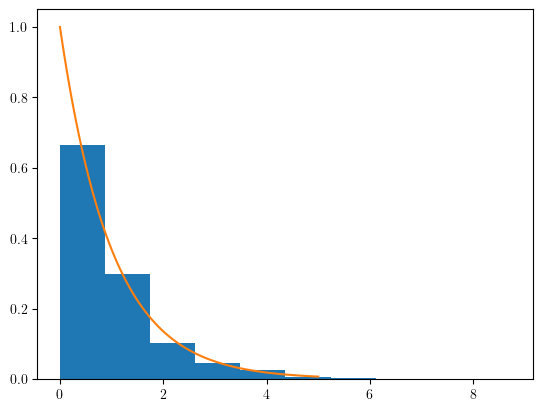

In [26]:
sampled = np.random.rand(1000)
transform_u = lambda u, A: -np.log(u)/A
x = np.linspace(0, 5, 100)

plt.hist(transform_u(sampled, 1), density=True)
plt.plot(x, np.exp(-x))
plt.savefig('../deliverables/figures/exp_dist.pdf')

In [3]:
radiation_length = 5.80
initial_energy = 1e+3 #  MeV
ion_loss_rate = 2.
brem_crit = 6.9
m_e = 0.511 # MeV
max_particles = 1000000

def cascade_trial(radiation_length=5.80, initial_energy=1e+3, ion_loss_rate=2., brem_crit=6.9, m_e=0.511, max_particles=1000000):
    photons = np.zeros((max_particles, 3))
    photon_count = 1 # number of photons that have ever been created

    charged = np.zeros((max_particles, 3))
    charged_count = 0 # number of charged particles that have ever been created

    brem_events = 0
    pair_events = 0

    photons[0, 0] = initial_energy
    photons[0, 2] = 1  # active
    # 0: energy, 1: distance, 2: active
    while (photons[:,0] > 2*m_e).sum() > 0:
        # photon effects
        productive = photons[:, 0] > 2*m_e
        pair_events += len(photons[productive])
        photons[productive, 1] += exponential(size=max_particles, scale=(9/7)*radiation_length)[productive]
        for i in range(productive.sum()):
            charged[charged_count, :] = np.array([
                photons[productive, 0][i]/2,
                photons[productive, 1][i],
                1
            ])
            charged[charged_count+1, :] = np.array([
                photons[productive, 0][i]/2,
                photons[productive, 1][i],
                1
            ])
            charged_count += 2

        photons[productive, 0] = 0.
        photons[productive, 2] = 0

        # charged particle effects
        for i in np.argwhere(charged[:, 0] > brem_crit).flatten():
            travel = exponential(scale=radiation_length)
            brem_energy = charged[i, 0] * (1 - np.exp(-travel/radiation_length))

            charged[i, :] = np.array([
                charged[i, 0] - brem_energy - ion_loss_rate*travel,
                charged[i, 1] + travel,
                1
            ])
            charged[i, 0] = charged[i, 0] if charged[i, 0] > 0 else 0.
            charged[i, 2] = 1 if charged[i, 0] > 0 else 0.

            photons[photon_count, :] = np.array([
                brem_energy,
                charged[i, 1],
                1
            ])
            photon_count += 1
            brem_events += 1

    return photons, charged, brem_events, pair_events

In [4]:
total_charged = []
total_photons = []
for i in range(100):
    photons, charged, brem_events, pair_events = cascade_trial()
    total_charged.append(charged[charged[:, 1] > 0, :])
    total_photons.append(photons[photons[:, 1] > 0, :])
    
total_charged = np.vstack(total_charged)
total_photons = np.vstack(total_photons)

KeyboardInterrupt: 

In [81]:
charged_save = DataFrame(total_charged, columns=['Energy (MeV)', 'Depth (g/cm2)', 'Active'])
charged_save.to_csv('data/charged.csv', index=False)

photon_save = DataFrame(total_charged, columns=['Energy (MeV)', 'Depth (g/cm2)', 'Active'])
photon_save.to_csv('data/photon.csv', index=False)

[[Model]]
    Model(fit_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 70
    # variables        = 3
    chi-square         = 44019.8421
    reduced chi-square = 657.012569
    Akaike info crit   = 457.073037
    Bayesian info crit = 463.818523
    R-squared          = 0.99324071
[[Variables]]
    a:  0.00855297 +/- 0.00226803 (26.52%) (init = 0.008)
    b:  3.97731997 +/- 0.08930294 (2.25%) (init = 4)
    c:  12.3818946 +/- 0.25405326 (2.05%) (init = 13)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.9963
    C(b, c) = -0.9723
    C(a, c) = +0.9497


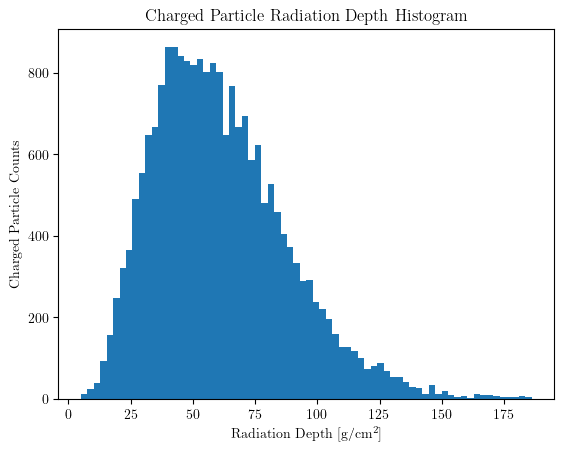

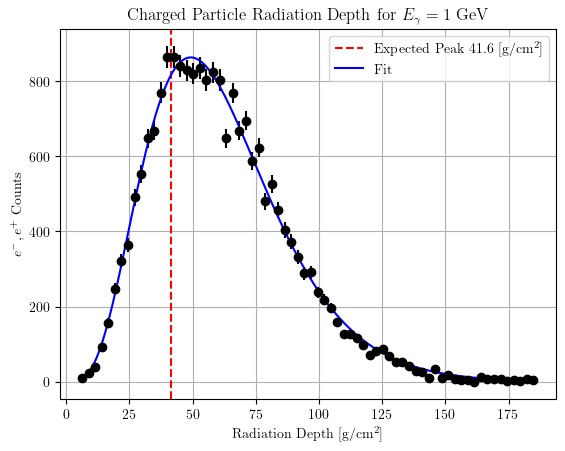

In [28]:
total_charged = read_csv('data/charged.csv')
total_photons = read_csv('data/photon.csv')

bin_counts, bin_edges, _ = plt.hist(total_charged['Depth (g/cm2)'], density=False, bins='auto');
plt.xlabel('Radiation Depth [g/cm$^2$]')
plt.ylabel('Charged Particle Counts')
plt.title('Charged Particle Radiation Depth Histogram')
plt.savefig('../deliverables/figures/charged_depth_hist.pdf')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

def fit_function(x, a, b, c):
    return a * x ** b * np.exp(-x / c)

x = bin_centers
y = bin_counts

fit_model = Model(fit_function)
params = fit_model.make_params(a=8e-3, b=4., c=13)
results = fit_model.fit(y, params, x=x)
x_fit = np.linspace(
    bin_centers.min(),
    bin_centers.max(),
    500
)

fig, ax = plt.subplots()
ax.grid()
ax.errorbar(bin_centers, bin_counts, yerr=np.sqrt(bin_counts), fmt='o', color='black')
ax.set_xlabel('Radiation Depth [g/cm$^2$]')
ax.set_ylabel('$e^-,e^+$ Counts')
ax.set_title('Charged Particle Radiation Depth for $E_\\gamma = 1$ GeV')

expected_peak = np.log(initial_energy / brem_crit) / np.log(2.) * radiation_length
ax.axvline(expected_peak, color='red', linestyle='--', label=f'Expected Peak {expected_peak:.3} [g/cm$^2$]')

ax.plot(x_fit, fit_model.eval(results.params, x=x_fit), label='Fit', color='blue')
ax.legend()

fig.savefig('../deliverables/figures/charged_depth_results.pdf')
print(results.fit_report())

- errorbars of a histogram [Histograms](https://www.quarknet.org/sites/default/files/histogram_uncertainty_tchr_31oct19.pdf):
> When collecting data by counting, the underlying statistical distribution is a Poisson distribution
because counting can never be negative. Since particle physicists perform counting experiments, the
uncertainty in a count is determined using the standard deviation for the Poisson distribution $$\sqrt{N}$$

## Other analyses
- Modeling how fit parameters vary with bin count/width